In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab

from matplotlib import rc
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist
from scipy.special import expit
from scipy.stats import bernoulli
from numpy.polynomial.polynomial import polyval

from scipy.optimize import minimize
from scipy.stats import norm, laplace

import functools

%matplotlib inline

## Data Generation

In [2]:
# set the random seed
random.seed(123)

In [3]:
# generate data from the marginal distributions P(X_0) and P(X_1)
ns = 500
d  = 5
X0 = np.random.randn(ns,d)
X1 = np.random.laplace(0,0.2,size=(ns,d))

In [4]:
# generate Y_0 and Y_1 from the conditional models
b = 1.0
beta_vec  = np.array([0.1,0.2,0.3,0.4,0.5])
Y0 = np.dot(beta_vec,X0.T) + 0.1*np.random.randn(X0.shape[0])      # potential outcome Y_0
Y1 = np.dot(beta_vec,X1.T) + b + 0.1*np.random.randn(X1.shape[0])  # potential outcome Y_1

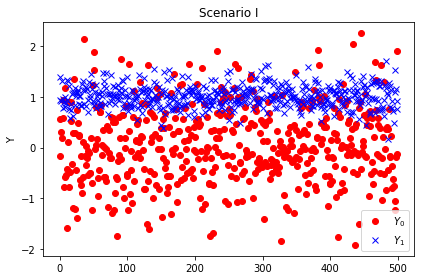

In [5]:
# plot the true functions and the samples
fig, ax = plt.subplots(1,1)

ax.plot(Y0,linewidth=1,linestyle="None",marker='o',color='red',label="Y_0")
ax.plot(Y1,linewidth=1,linestyle="None",marker='x',color='blue',label="Y_1")
ax.legend(["$Y_0$","$Y_1$"])
ax.set_title(r"Scenario I")
ax.set_ylabel(r"Y")
fig.tight_layout()

In [6]:
# save the figure
fig.savefig('cf_data.pdf',dpi=100)

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


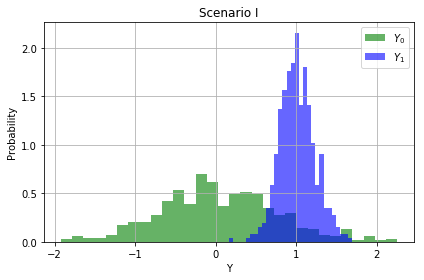

In [7]:
# plot the histograms
fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(Y0,30,normed=1,facecolor='green', alpha=0.6, label="$Y_0$")
y0 = mlab.normpdf(bins, 0, 1)

n, bins, patches = ax.hist(Y1,30,normed=1,facecolor='blue', alpha=0.6,label="$Y_1$")
y1 = mlab.normpdf(bins, 2, 1)

ax.legend()
ax.set_title(r"Scenario I")
ax.set_ylabel(r"Probability")
ax.set_xlabel(r"Y")
ax.grid(True)

fig.tight_layout();

In [8]:
# save the figure
fig.savefig('cf_data_hist.pdf',dpi=100)

## Construct Counterfactual Mean Embedding

In [9]:
# kernel function
def gauss_rbf(X1,X2,sigma=1):
    """
    The Gaussian RBF kernel function.
    X1 : the first nxd input data matrix. Each row corresponds to data point
    X2 : the second mxd input data matrix. Each row corresponds to the data point
    """
    
    K = np.exp(-np.divide(cdist(X1,X2,'sqeuclidean'),2*sigma))
    
    return K
###

In [10]:
# Now, given the generated data, construct the estimate of the counterfactual distributions

reg_param = 1e-6

sg = np.median(pairwise_distances(X0, X1, metric='euclidean'))**2

K1 = gauss_rbf(X1,X1,sg)
K2 = gauss_rbf(X1,X0,sg)

# beta vector
b = np.dot(np.dot(np.linalg.inv(K1 + ns*reg_param*np.eye(ns)),K2),np.ones((ns,1))/ns)
print(sum(b))

[0.91471345]


## Fit Counterfactual Distribution

In [11]:
Yt = np.linspace(-2,2,100)
Yt = Yt[:,np.newaxis]
YY0 = Y0[:,np.newaxis] # Y

sg = np.median(pairwise_distances(YY0,Yt,metric='euclidean'))**2

In [12]:
def obj_fun(x, YY=None, b=None, sg=None):
    """ x[0]: mean of the Gaussian, x[1]: variance of the Gaussian """
    
    gm = 1.0/sg
        
    first_term  = np.dot(np.dot(b.T,gauss_rbf(YY,YY,sg)),b)
    second_term = np.dot(b.T,np.exp(-0.5*(x[1]**2 + sg)*((YY - x[0])**2))/np.sqrt(gm*(x[1]**2) + 1))
    third_term  = 1.0/np.sqrt(2*(x[1]**2) + 1)
    
    return first_term - 2*second_term + third_term


In [13]:
obj_fn = functools.partial(obj_fun, YY=YY0, b=b, sg=sg)

x0 = np.array([YY0.mean(axis=0),YY0.var(axis=0)]).ravel()
res = minimize(obj_fn, x0, method='CG', options={'gtol': 1e-6, 'disp': True})
while (not res.success):
    x0 = np.array([YY0.mean(axis=0) + 1e-3*np.random.randn(),YY0.var(axis=0)]).ravel()
    res = minimize(obj_fn, x0, method='CG', options={'gtol': 1e-6, 'disp': True})

mm = res.x[0]
ss = res.x[1]
print(mm,ss,res.success)

Optimization terminated successfully.
         Current function value: 0.001881
         Iterations: 6
         Function evaluations: 52
         Gradient evaluations: 13
0.1767920963518843 0.3642285596065059 True


## Plot Counterfactual Distribution

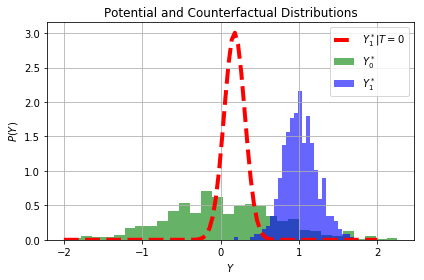

In [14]:
# plot the histograms
fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(Y0,30,density=True,facecolor='green', alpha=0.6, label="$Y^*_0$")

n, bins, patches = ax.hist(Y1,30,density=True,facecolor='blue', alpha=0.6, label="$Y^*_1$")
ax.plot(Yt, norm.pdf(Yt,loc=mm,scale=ss**2),'r--',linewidth=4,label="$Y^*_1|T=0$");

ax.legend()
ax.set_title("Potential and Counterfactual Distributions")
ax.set_xlabel("$Y$")
ax.set_ylabel("$P(Y)$")
ax.grid(True)

fig.tight_layout();

In [15]:
# save the figure
fig.savefig('cf_distributions.pdf', dpi=100)

## Kernel Herding

In [16]:

# simplify kernel function to avoid dimension crashing
def rbf_kernel(X1,X2,sigma=1):
    
    K = np.exp(-((X1 - X2)**2)/(2*sigma))
    return K

# sample size
m = 200

sg = np.median(pairwise_distances(YY0,metric='euclidean'))**2

# minimization problem in each step
def obj_fun_herding(y, yt_hist=None, t=None):
    first_term  = np.dot(b.T,rbf_kernel(YY0,y,sg))
    if yt_hist is None:
        return -first_term
    else:
        second_term = (1.0/(t+1))*rbf_kernel(yt_hist,y,sg).sum()
    return -first_term + second_term

# the MMD objective
def mmd_obj(ys,yt,bs,sigma): 
    mvec = np.repeat(1.0/len(yt),len(yt))
    first_term = np.dot(np.dot(mvec.T,gauss_rbf(yt,yt,sigma)),mvec)
    second_term = np.dot(np.dot(bs.T,gauss_rbf(ys,yt,sigma)),mvec)
    third_term = np.dot(np.dot(bs.T,gauss_rbf(ys,ys,sigma)),bs)
    
    return first_term - 2*second_term + third_term
    
# first iteration
obj_fn = functools.partial(obj_fun_herding, yt_hist=None, t=None)
y0 = YY0.mean(axis=0)
res = minimize(obj_fn, y0, method='CG', options={'gtol': 1e-10, 'disp': False})
yt = res.x.ravel()[0]

# initialize samples
yt_samples = [yt]
obj_val = [mmd_obj(YY0,np.array(yt_samples)[:,np.newaxis],b,sg).flatten()]

# start the iterations 2 to m
max_trials = 10
for t in range(2, m+1):
    yt_hist = np.array(yt_samples)
    obj_fn = functools.partial(obj_fun_herding, yt_hist=yt_hist, t=t)
    res = minimize(obj_fn, y0, method='CG', options={'gtol': 1e-10, 'disp': False})
    
    num_trials = 0 
    while (not res.success and num_trials < max_trials):
        res = minimize(obj_fn, y0 + 1e-5*np.random.randn(), method='CG', options={'gtol': 1e-10, 'disp': False})
        num_trials += 1
        
    yt = res.x.ravel()[0]
    yt_samples += [yt]
    obj_val += [mmd_obj(YY0,np.array(yt_samples)[:,np.newaxis],b,sg).flatten()]

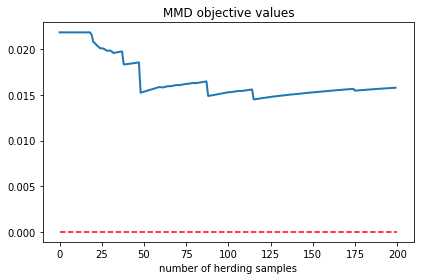

In [17]:
# plot the histograms
fig, ax = plt.subplots(1,1)
ax.plot(range(m),obj_val,linewidth=2)

ax.set_title("MMD objective values")
ax.set_xlabel("number of herding samples")
ax.hlines(0.0, 0, m, colors='r', linestyles='dashed')

fig.tight_layout();

In [18]:
# save the figure
fig.savefig('cf_mmd_objective.pdf', dpi=100)

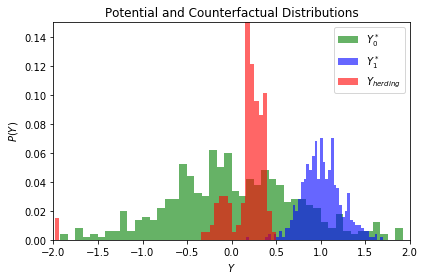

In [19]:
yt_samples = [y for y in yt_samples if y > -2 and y < 2]

# plot the histograms
fig, ax = plt.subplots(1,1)
n, bins, patches = ax.hist(Y0, 50, weights=np.ones_like(Y0) / len(Y0), facecolor='green', alpha=0.6, label="$Y^*_0$")
n, bins, patches = ax.hist(Y1, 50, weights=np.ones_like(Y1) / len(Y1), facecolor='blue', alpha=0.6, label="$Y^*_1$")
n, bins, patches = ax.hist(yt_samples, 50, weights=np.ones_like(yt_samples) / len(yt_samples), facecolor='red', alpha=0.6, label="$Y_{herding}$")

ax.legend()
ax.set_title("Potential and Counterfactual Distributions")
ax.set_xlabel("$Y$")
ax.set_ylabel("$P(Y)$")
ax.axes.set_xlim((-2, 2))
ax.axes.set_ylim((0.0,0.15))

fig.tight_layout();

In [20]:
# save the figure
fig.savefig('cf_distributions_herding.pdf', dpi=100)

In [21]:
yt_samples

[0.20197854661780917,
 0.20197854536315368,
 0.2019785162364237,
 0.20197856791838625,
 0.20197856121314411,
 0.2019785240759635,
 0.201978555087475,
 0.2019785923970262,
 0.20197847617840536,
 0.20197858975678562,
 0.20197851822512397,
 0.2019785889725732,
 0.2019783027217874,
 0.20197919973345707,
 0.2019777618989828,
 0.20197932909301566,
 0.20197712964936063,
 0.20198280025603443,
 0.2019570824238576,
 -0.04038744831449666,
 0.5014251765935034,
 0.016242320611541787,
 0.4041734478469804,
 -0.012145721360354975,
 0.39649922022030043,
 0.0791108168678572,
 0.33646461815117384,
 -0.023270712665375903,
 0.4021964545621241,
 0.11172404984245468,
 0.31037280225830494,
 -0.08019703215280502,
 0.4213884994943868,
 0.2056977247509476,
 0.19728452366435895,
 0.21077023371596465,
 0.16807779595082675,
 0.2957534205202056,
 0.12908713103055258,
 0.21019888304973028,
 0.20104598792954426,
 0.20223662637973094,
 0.20185901337184498,
 0.20206474153245563,
 0.20188555186385218,
 0.2021308573559530